## Notebook 2. 

We perform the same modelling as in Notebook 1 but using only the counts during the wet season (May - October). This is because we are likely to conduct our releases during the wet season hence we should focus more on this duration. Another reason is that including the dry season counts with many 0 entires may have bad impact on the models we built. 

In [2]:
# LOAD R PACKAGES
require(compiler)
enableJIT(3)
setMKLthreads(22)
require(lme4)
require(lmerTest)
require(MASS)

# LOAD DATASET dat1
#setwd('variance/Florian')
load('Per house data PSC 2012 to 2019 polish2.RData')
load('BF_weather.RData')
ls()
dim(dat1)

Loading required package: compiler


[1] 3

Loading required package: lme4
Loading required package: Matrix
Loading required package: lmerTest

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

Loading required package: MASS


[1] "BV_weather" "dat1"       "PL_weather" "SK_weather"

[1] 3212   26

In [3]:
# SUBSET (MAY-OCTOBER ONLY)
dat1<-dat1[dat1$month.assigned %in% 5:10,]
# dat1 GOT OVER-WRITTEN SO YOU NEED TO BE CAREFUL. 
dim(dat1)

[1] 1626   26

Obviously choosing only wet season counts will reduce the number of data points (from 3212 to 1626 rows). It has no impact on the number of columns (variables). We can run some descriptive stats like we did before. 

### Descriptive statistics

In [3]:
# SOME DESCRIPTIVE STATISTICS ON THE RESPONSE VARIABLE, THAT IS, FEMALE MOSQUITO COUNT
cat('overall summary of count')
summary(dat1$count.f)
cat('mean count per month')
by(dat1$count.f, dat1$month.assigned, mean, na.rm=T)
cat('mean count per year')
by(dat1$count.f, dat1$year.assigned, mean, na.rm=T)
cat('mean count per village')
by(dat1$count.f, dat1$village, mean, na.rm=T)

overall summary of count

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    2.00    6.00   15.81   17.00  333.00      12 

mean count per month

dat1$month.assigned: 1
[1] NA
------------------------------------------------------------ 
dat1$month.assigned: 2
[1] NA
------------------------------------------------------------ 
dat1$month.assigned: 3
[1] NA
------------------------------------------------------------ 
dat1$month.assigned: 4
[1] NA
------------------------------------------------------------ 
dat1$month.assigned: 5
[1] 16.57831
------------------------------------------------------------ 
dat1$month.assigned: 6
[1] 9.812139
------------------------------------------------------------ 
dat1$month.assigned: 7
[1] 15.21667
------------------------------------------------------------ 
dat1$month.assigned: 8
[1] 14.49857
------------------------------------------------------------ 
dat1$month.assigned: 9
[1] 26.59649
------------------------------------------------------------ 
dat1$month.assigned: 10
[1] 15.98261
------------------------------------------------------------ 
dat1$month.assigned: 11
[1] NA
------------

mean count per year

dat1$year.assigned: 2012
[1] 28.27308
------------------------------------------------------------ 
dat1$year.assigned: 2013
[1] 16.19429
------------------------------------------------------------ 
dat1$year.assigned: 2014
[1] 9.402878
------------------------------------------------------------ 
dat1$year.assigned: 2017
[1] 13.15132
------------------------------------------------------------ 
dat1$year.assigned: 2018
[1] 12.84746
------------------------------------------------------------ 
dat1$year.assigned: 2019
[1] 12.81955

mean count per village

dat1$village: Bana market
[1] 16.81724
------------------------------------------------------------ 
dat1$village: Bana village
[1] 22.45911
------------------------------------------------------------ 
dat1$village: Pala
[1] 11.81
------------------------------------------------------------ 
dat1$village: Souroukoudingan
[1] 9.948187

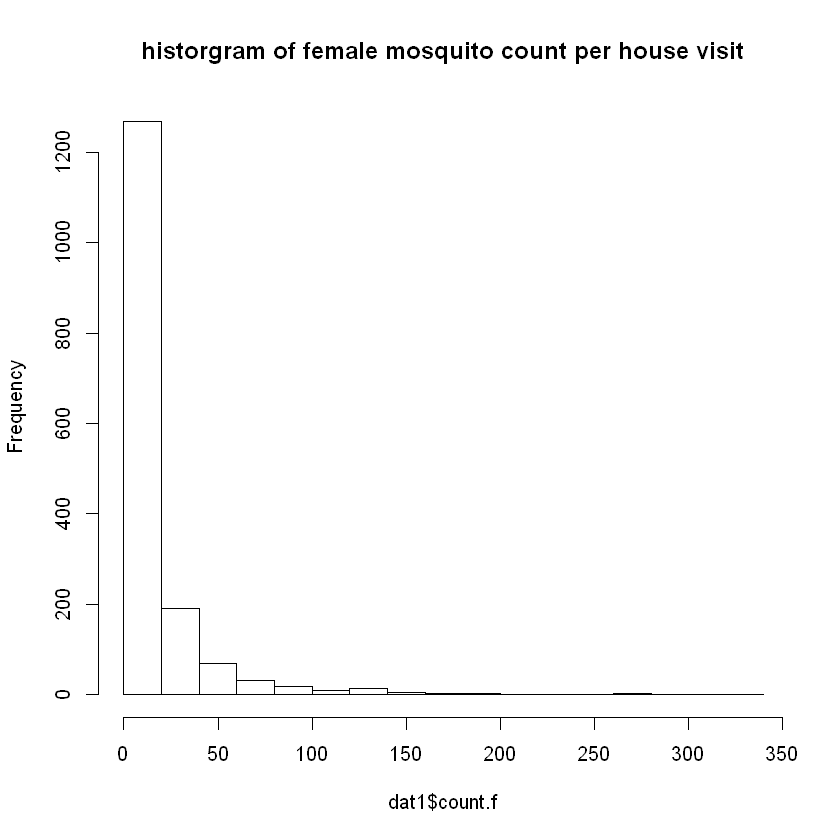

In [4]:
# HISTOGRAM OF THE RESPONSE
hist(dat1$count.f, main='historgram of female mosquito count per house visit')

In [5]:
# DESCRIPTIVE STATS ON SOME EXPLANATORY VARIABLES AS WELL
cat('number of unqiue days of data collection')
length(unique(dat1$date.collection))
cat('number of unique houses we visited')
length(unique(dat1$site.id))
cat('summary of mosquito.net')
by(dat1$mosquito.net, dat1$village, summary)
cat('summary of number of persons in house')
summary(dat1$num.persons)

number of unqiue days of data collection

[1] 81

number of unique houses we visited

[1] 284

summary of mosquito.net

dat1$village: Bana market
  No  Yes NA's 
  25  263    4 
------------------------------------------------------------ 
dat1$village: Bana village
  No  Yes NA's 
  34  491   19 
------------------------------------------------------------ 
dat1$village: Pala
  No  Yes NA's 
  75  321    4 
------------------------------------------------------------ 
dat1$village: Souroukoudingan
  No  Yes NA's 
  27  360    3 

summary of number of persons in house

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.182   4.000  16.000      38 

The mean counts are of course higher when we only include data points from the wet season. 

### Modelling
Let us go straight to models 4B and 5 in Notebook 1. They are the poisson glm models with month.assigned, village, mosquito.ne, persons.status as fixed effects, and year.assigned, site.id, overdisperson as random effects. In model 5 we include the interaction between month.assigned and village. 

In [4]:
# MODEL 4B
# THREE LEVELS OF PERSONS: None, Low, Hi. 
dat1$persons.status<-dat1$num.persons
dat1$persons.status[dat1$num.persons>3]<-'Hi'
dat1$persons.status[dat1$num.persons<=3]<-'Low'
dat1$persons.status[dat1$num.persons==0]<-'None'
dat1$persons.status<-factor(dat1$persons.status, levels=c('None', 'Low', 'Hi'))
overdispersion<-1:nrow(dat1)
m_4B<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned+village+mosquito.net+persons.status, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_4B, correlation=FALSE)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned + village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 11225.1  11305.6  -5597.6  11195.1     1566 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.34973 -0.33402 -0.00801  0.12757  0.54228 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.28413  1.1332  
 site.id        (Intercept) 0.41523  0.6444  
 year.assigned  (Intercept) 0.09817  0.3133  
Number of obs: 1581, groups:  
overdispersion, 1581; site.id, 278; year.assigned, 6

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.37251    0.55238   2.485 0.012966 *  
month.assign

In [5]:
# MODEL 5. ADD INTERACTION BETWEEN village AND month.assigned
overdispersion<-1:nrow(dat1)
m_5<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_5, correlation=FALSE)


Correlation matrix not shown by default, as p = 27 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 11207.0  11367.9  -5573.5  11147.0     1551 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.39317 -0.32426 -0.01092  0.12816  0.58715 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.2350   1.1113  
 site.id        (Intercept) 0.4070   0.6380  
 year.assigned  (Intercept) 0.1096   0.3311  
Number of obs: 1581, groups:  
overdispersion, 1581; site.id, 278; year.assigned, 6

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                              1.22601    0.56217   2

We can run an ANOVA to compare model 4B and 5. 

In [8]:
anova(m_4B, m_5, test='LRT')

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
m_4B,15,11225.10,11305.59,-5597.550,11195.10,NA,NA,NA
m_5,30,11206.97,11367.94,-5573.483,11146.97,48.13393,15,2.419603e-05


The ANOVA suggests that model 5 with interaction has a better fit, that it is worth spending 15 additional degrees of freedom (parameters) in exchange for a higher explanatory power. Further pairwise/stepwise comparisons can help pick up the significant interaction terms. 

As before, we can visualise the interaction by looking at the parallelness of the mean month counts. 

mean monthly count per village

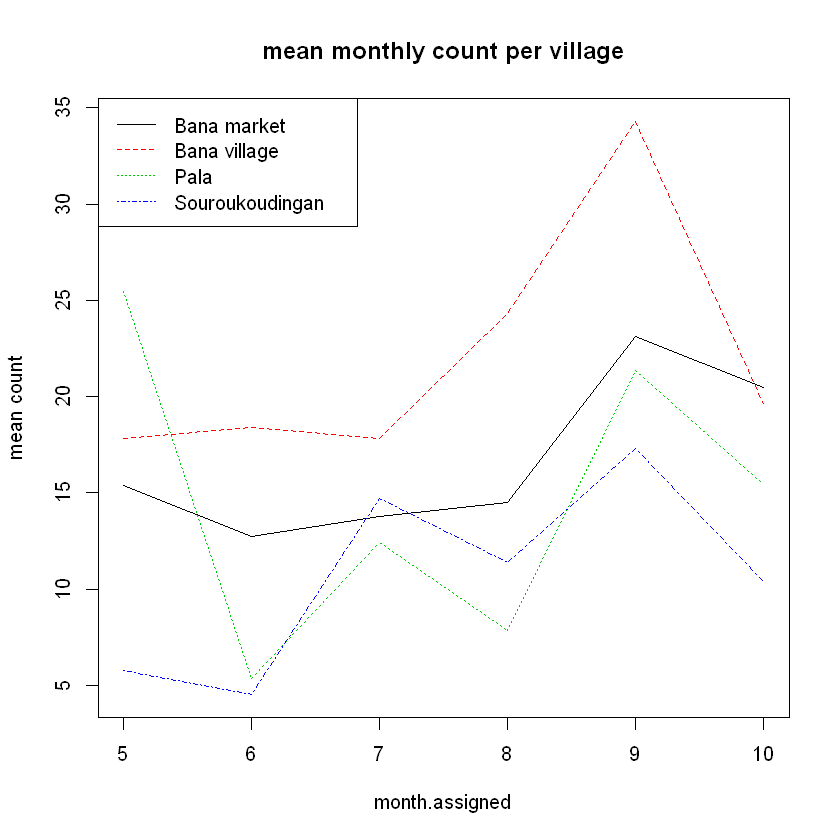

In [14]:
cat('mean monthly count per village')
#cbind(month.assigned=levels(dat1$month.assigned), tapply(dat1$count.f, list(dat1$month.assigned, dat1$village), mean, na.rm=T))
matplot(tapply(dat1$count.f, list(dat1$month.assigned, dat1$village), mean, na.rm=T), 
        type='l', xlim=c(5,10), xlab='month.assigned', ylab='mean count', main='mean monthly count per village')
legend('topleft', legend=levels(dat1$village), col=1:4, lty=1:4)

Another variable I want to explore is the male mosquito count observed during the same house visit. I suppose the female and male counts are (positively) correlated, and that knowing the male counts may give some information on the female counts. Note that in an earlier exercise we know that the male counts are usually much lower. I use log(dat$count.m+1) as the covariate. The "plus one" is to avoid log(0) while transforming, and using the log male count to model the log female rate seems legit. 

In [13]:
# MODEL 6, ADD LOG OF MALE COUNT AS COVARIATE
# I ALSO CHECKED (NOT SHOWN) THAT THE INTERACTION TERM IS TO STAY
overdispersion<-1:nrow(dat1)
log.count.m<-log(dat1$count.m+1)
m_6<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status+log.count.m, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_6)


Correlation matrix not shown by default, as p = 28 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status +      log.count.m
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 10713.8  10880.1  -5325.9  10651.8     1550 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.45851 -0.35726 -0.02856  0.16034  0.72388 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 0.87693  0.9364  
 site.id        (Intercept) 0.17834  0.4223  
 year.assigned  (Intercept) 0.02924  0.1710  
Number of obs: 1581, groups:  
overdispersion, 1581; site.id, 278; year.assigned, 6

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                              0.6

We can see that the log male count from the same house visit is a great covariate. It reduces the variances of all 3 random effects. In other words, good/bad year and houses are partially represented by this covariate. 

### Conclusion
The variance estimates of the random effects are quite consistent thoughout. Over-dispersion remains the largest components, followed by site.id (individual house effect) and yearly effect. Including male mosquito count as covariate reduces all the variance estimates, which will be useful in power analysis. 

For the main effects, more persons within a house increases the rate. Mosquito net decreases the rate but only by a little (not quite significant). For the villages, Souroukoudingan has the lowest rate and this effect is significant. The interaction between village and month.asigned exists. The significance of the terms are quite sensitive to which subset you choose to analyse. 

The next notebook tries to incorporate weather station info to the analysis. 